In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from micrograd.engine import Tensor
from micrograd.nn import MultiLayerPerceptron

np.random.seed(1337)
random.seed(1337)

## Data

In [2]:
train_data = datasets.MNIST(root="./data", train=True, download=True)
test_data = datasets.MNIST(root="./data", train=False, download=True)

# Convert to numpy arrays and normalize
X_train = train_data.data.numpy().reshape(-1, 28 * 28) / 255.0
y_train = train_data.targets.numpy()
X_test = test_data.data.numpy().reshape(-1, 28 * 28) / 255.0
y_test = test_data.targets.numpy()

100%|██████████| 9.91M/9.91M [00:00<00:00, -32.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 127kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 997kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.68MB/s]


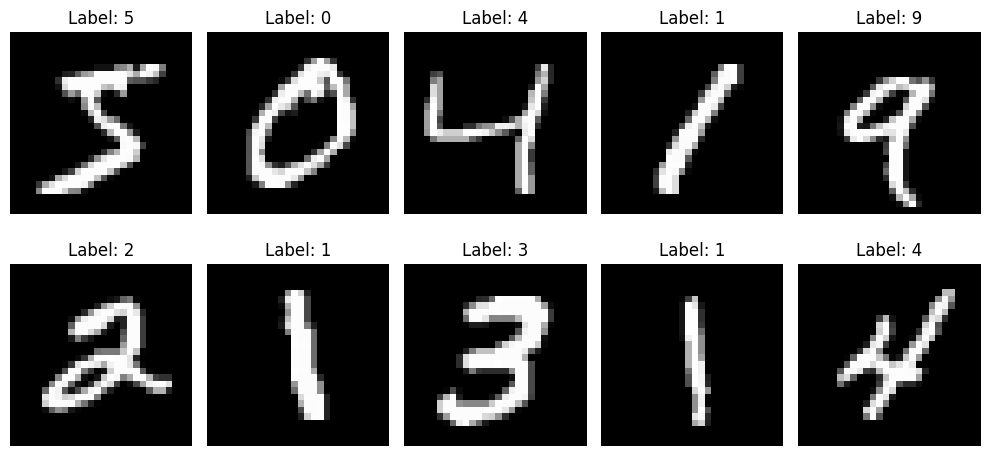

In [3]:
# Visualize some samples
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()

## Model

In [4]:
model = MultiLayerPerceptron(28 * 28, [128, 64, 10], init="glorot")  # 3-layer neural network
print("No. of params", sum([p.numel() for p in model.parameters()]))

for layer in model.layers:
    print(layer)

No. of params 109386
Layer(128, act=relu)
Layer(64, act=relu)
Layer(10, act=None)


## Loss

In [5]:
def cross_entropy_loss(X_batch, y_batch):
    inputs = [Tensor(x) for x in X_batch]

    # Forward pass
    logits = list(map(model, inputs))

    # Cross-entropy loss
    losses = []
    for i in range(len(logits)):
        log_probs = logits[i].log_softmax()
        losses.append(-log_probs[y_batch[i]])

    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = 0.0
    for p in model.parameters():
        reg_loss = reg_loss + (p * p).sum()
    reg_loss = alpha * reg_loss

    total_loss = data_loss + reg_loss

    # Calculate accuracy
    preds = np.array([np.argmax([l.data for l in logit]) for logit in logits])
    accuracy = np.mean(preds == y_batch)

    return total_loss, accuracy

## Training

In [6]:
batch_size = 64
num_epochs = 20
learning_rate = 0.01
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    # Shuffle data
    permutation = np.random.permutation(len(X_train))
    X_train = X_train[permutation]
    y_train = y_train[permutation]

    epoch_loss = 0.0
    epoch_acc = 0.0
    num_batches = 0

    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i : i + batch_size]
        y_batch = y_train[i : i + batch_size]

        # Forward and backward pass
        total_loss, acc = cross_entropy_loss(X_batch, y_batch)
        model.zero_grad()
        total_loss.backward()

        # Update parameters
        for p in model.parameters():
            p.data -= learning_rate * p.grad

        epoch_loss += total_loss.item
        epoch_acc += acc
        num_batches += 1

    # Print epoch statistics
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches
    losses[epoch] = avg_loss
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc * 100:.2f}%")

Epoch 1/20, Loss: 1.4643, Accuracy: 65.52%
Epoch 2/20, Loss: 0.5020, Accuracy: 86.78%
Epoch 3/20, Loss: 0.3860, Accuracy: 89.56%
Epoch 4/20, Loss: 0.3424, Accuracy: 90.70%
Epoch 5/20, Loss: 0.3147, Accuracy: 91.43%
Epoch 6/20, Loss: 0.2936, Accuracy: 91.99%
Epoch 7/20, Loss: 0.2755, Accuracy: 92.52%
Epoch 8/20, Loss: 0.2598, Accuracy: 93.04%
Epoch 9/20, Loss: 0.2459, Accuracy: 93.49%
Epoch 10/20, Loss: 0.2332, Accuracy: 93.84%
Epoch 11/20, Loss: 0.2220, Accuracy: 94.19%
Epoch 12/20, Loss: 0.2121, Accuracy: 94.46%
Epoch 13/20, Loss: 0.2032, Accuracy: 94.72%
Epoch 14/20, Loss: 0.1947, Accuracy: 94.95%
Epoch 15/20, Loss: 0.1871, Accuracy: 95.17%
Epoch 16/20, Loss: 0.1800, Accuracy: 95.37%
Epoch 17/20, Loss: 0.1733, Accuracy: 95.59%
Epoch 18/20, Loss: 0.1674, Accuracy: 95.73%
Epoch 19/20, Loss: 0.1619, Accuracy: 95.96%
Epoch 20/20, Loss: 0.1564, Accuracy: 96.08%


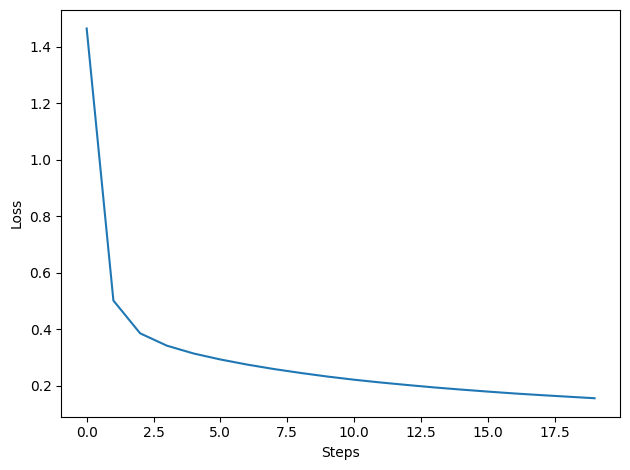

In [7]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.tight_layout()

## Test

In [8]:
test_loss, test_acc = cross_entropy_loss(X_test, y_test)
print(f"Test Loss: {test_loss.item:.4f} Accuracy: {test_acc * 100:.2f}%")

Test Loss: 0.1618 Accuracy: 95.81%


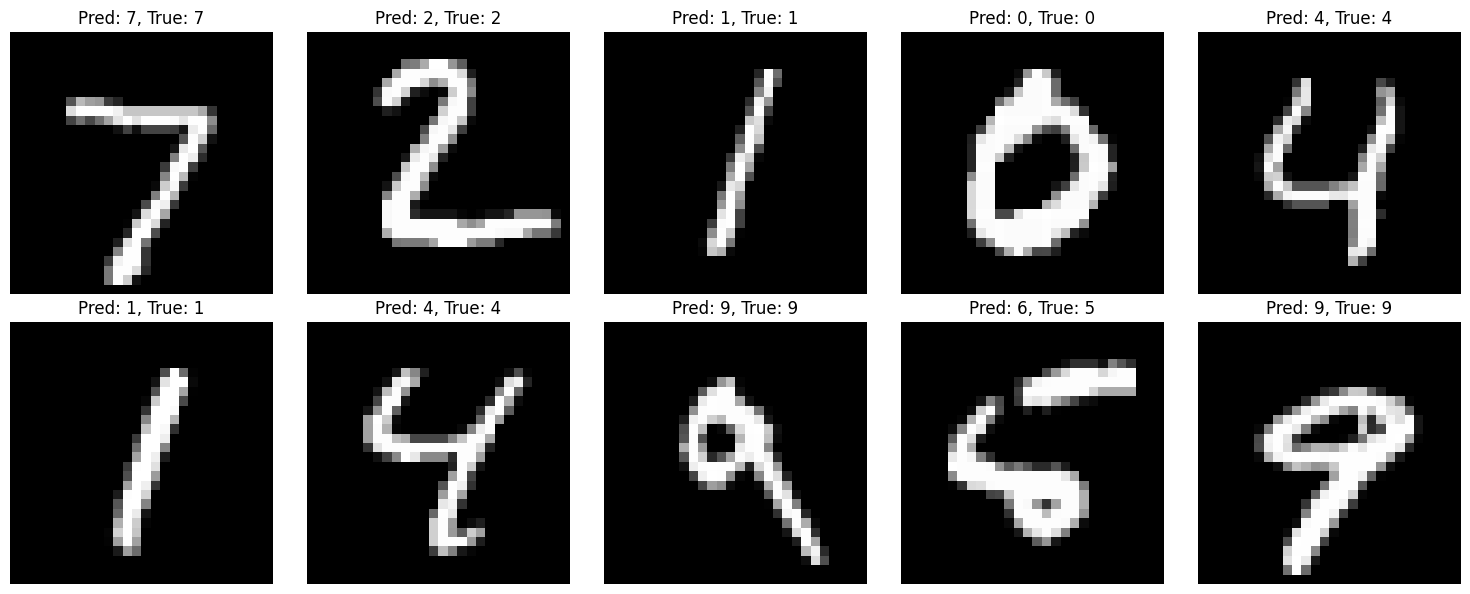

In [9]:
# Visualize some predictions
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sample = X_test[i]
    plt.imshow(sample.reshape(28, 28), cmap="gray")

    logits = model(Tensor(sample))
    pred = np.argmax([l.data for l in logits])

    plt.title(f"Pred: {pred}, True: {y_test[i]}")
    plt.axis("off")
plt.tight_layout()

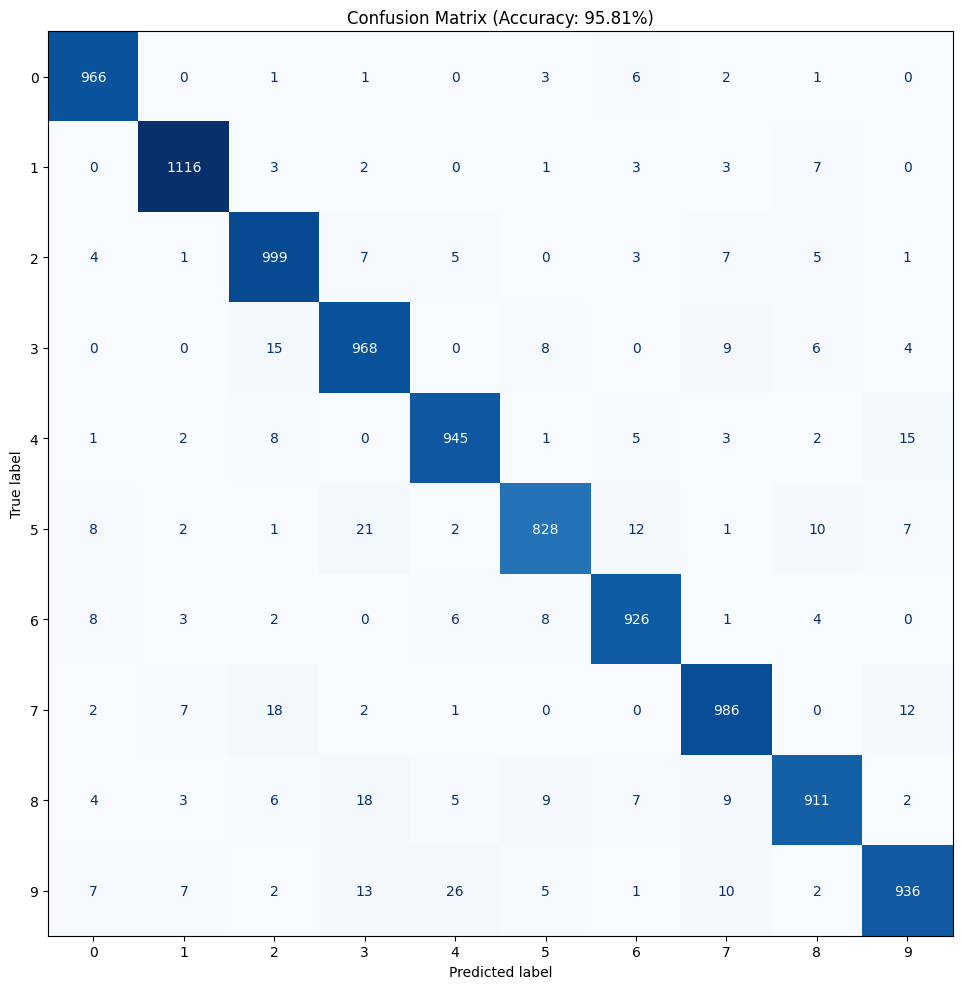

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

inputs = [Tensor(x) for x in X_test]
logits = list(map(model, inputs))
y_pred = np.array([np.argmax([l.data for l in logit]) for logit in logits])

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title(f"Confusion Matrix (Accuracy: {accuracy_score(y_test, y_pred):.2%})")
plt.tight_layout()
plt.show()